# Optimizer
Gets data and uses it to optimize a method (imported from method.py) using a loss function and tests it against unseen data


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
import torch
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Import data

In [64]:
### Load the data
seed = 1
data_path = 'data/output/data_complete_grouped_2022-06-30.csv'
df = pd.read_csv(data_path)

# Scale Data

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
M = scaler.fit_transform(df.drop(columns=['dataset']))
#M = df.drop(columns=['dataset']).to_numpy()
#y = M[:,-1]
y = df['Thermal feeling (global)'].to_numpy() + 1
X = M[:,:-1]
#X = M

[-0.55937073  3.20632201  0.52847036 -0.60714299 -1.24218101 -0.03318682
 -0.20247901 -0.02537922  0.28685266 -0.15448104  0.27503759]


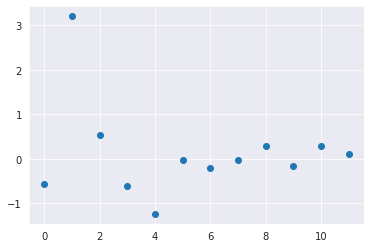

In [66]:
# Quick analysis of linear relationship of data
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X, y)

# display coefficients
print(regressor.coef_)
plt.scatter(np.arange(len(regressor.coef_)+1),regressor.coef_.tolist()+[regressor.intercept_])
plt.show()

# Train

In [67]:
from sklearn.utils import class_weight

class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights

tensor([1.3252, 0.8763, 0.9056])

In [68]:
# random index splitter
def test_train_indices(X, test_size, seed=42):
    size = X.shape[0]
    split = int(size*(1-test_size))
    np.random.seed(seed)
    indices = np.arange(size)
    np.random.shuffle(indices)
    return indices[:split], indices[split:]

In [69]:
def label_from_predictor(x):
    if x>1.33:
        return 2
    elif x<0.33:
        return 0
    else:
        return 1
label_from_predictor = np.vectorize(label_from_predictor)

In [70]:
from tqdm import tqdm
import time
from torch.optim.lr_scheduler import ExponentialLR
from methods import *
from torch import nn

import numpy as np
from sklearn.model_selection import KFold, train_test_split


test_values = []
predicted_values = []
datasets = []
seeds = []
methods = []
parameters =[]
plot = False

# Test split using K-Folds cross-validator

#k = 10
#kf = KFold(n_splits=k, shuffle=True, random_state=seed)
#for idx, (train_index, test_index) in enumerate(kf.split(X)):

for method_class in method_classes_list():

    for seed in tqdm(range(100), desc=method_class.__name__):
        train_index, test_index = test_train_indices(X, 0.2, seed=seed)

        # Slicing data according to kf split
        dtype = torch.float32
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # TODO: random seed for methods

        # Hyperparameters for one train test session
        torch.manual_seed(seed)
        method = method_class(input_size=x_train.shape[1],class_weights=class_weights)
        # {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}

        if method.optimizes:
            x_train = torch.tensor(x_train,dtype=dtype)
            x_test = torch.tensor(x_test, dtype=dtype)
            if method.type == 'predictor':
                y_test = torch.tensor(y_test, dtype=dtype).reshape(-1,1)
                y_train = torch.tensor(y_train, dtype=dtype).reshape(-1,1)
            elif method.type == 'classifier':
                y_test = torch.tensor(y_test, dtype=torch.int64).reshape(-1)
                y_train = torch.tensor(y_train, dtype=torch.int64).reshape(-1)

            criterion = method.criterion()
            params_to_be_optimized = method.get_parameters()
            optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
            #scheduler = ExponentialLR(optimizer, gamma=0.999)
            train_losses = []  # for plot
            test_losses = []  # for plot

            epochs = 100
            for epoch in range(epochs):
              iteration_time = time.time()
              optimizer.zero_grad()

              # forward pass
              y_train_predicted = method.predict(x_train)
              loss = criterion(y_train_predicted, y_train) #+ 0.01*method.calculate_regularization_loss()

              # backward pass
              loss.backward()
              optimizer.step()
              #scheduler.step()

              with torch.no_grad():
                y_train_predicted = method.predict(x_train)
                train_loss = criterion(y_train_predicted, y_train)
                train_losses.append(train_loss)

                y_test_predicted = method.predict(x_test)
                test_loss = criterion(y_test_predicted, y_test)
                test_losses.append(test_loss)

            if plot:
                plt.plot(train_losses, label='train loss')
                plt.plot(test_losses, label='test loss')
                plt.legend()
                plt.title(f'Seed = {seed}')
                plt.show()

            # Lists for Error Analysis df
            if method.type == "predictor":
                test_values += y_test.detach().numpy().reshape(-1).tolist()

                predicted_values += label_from_predictor(method.predict(x_test).detach().numpy().reshape(-1)).tolist()
                datasets += df['dataset'][test_index].tolist()
                seeds += [seed] * len(y_test)
                methods += [method.__class__.__name__] * len(y_test)
            elif method.type == "classifier":
                test_values += y_test.detach().numpy().tolist()
                predicted_values += torch.argmax(method.predict(x_test), dim=1).detach().numpy().tolist()
                datasets += df['dataset'][test_index].tolist()
                seeds += [seed] * len(y_test)
                methods += [method.__class__.__name__] * len(y_test)

        else:
            method.fit(x_train, y_train)

            test_values += y_test.tolist()
            predicted_values += method.predict(x_test).tolist()
            datasets += df['dataset'][test_index].tolist()
            seeds += [seed] * len(y_test)
            methods += [method.__class__.__name__] * len(y_test)

        with torch.no_grad():
            parameters.append(method.get_parameters())

AdaBoost: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


# Test Analysis

In [71]:
analysis_df = pd.DataFrame({'method': methods, 'seed': seeds, 'dataset':datasets, 'y': test_values, 'pred': predicted_values})

In [83]:
from datetime import datetime

analysis_df.to_csv(f'data/analysis/test_{datetime.date(datetime.now()).__str__()}', index=False)

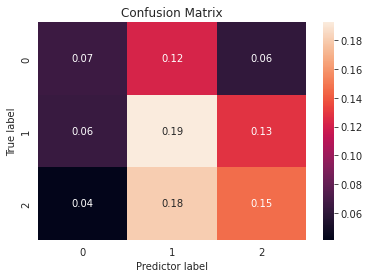

Accuracy: 0.4036868686868687


In [72]:
cm = confusion_matrix(analysis_df['y'], analysis_df['pred'])
cm = cm/cm.sum()
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predictor label')
plt.ylabel('True label')
plt.show()

print('Accuracy:', np.trace(cm))

# Train analysis

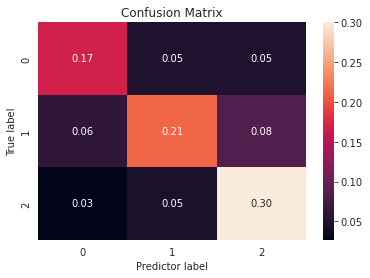

Accuracy: 0.6807692307692308


In [73]:
y_train_predicted = method.predict(x_train)

#cm = confusion_matrix(y_train.detach().numpy(), torch.argmax(y_train_predicted, dim=1).detach().numpy())
cm = confusion_matrix(y_train, y_train_predicted)
cm = cm/cm.sum()
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predictor label')
plt.ylabel('True label')
plt.show()
print('Accuracy:', np.trace(cm))
breakpoint()

## Predictor Analysis

In [74]:
analysis_df['error'] = analysis_df['y']-analysis_df['pred']
analysis_df['error_abs'] = np.abs(analysis_df['error'])
diff = analysis_df['y'].max()-analysis_df['y'].min()
analysis_df['accuracy'] = 1 - analysis_df['error_abs'] / diff

In [75]:
analysis_df['accuracy'].describe()

count    39600.000000
mean         0.650556
std          0.322337
min          0.000000
25%          0.500000
50%          0.500000
75%          1.000000
max          1.000000
Name: accuracy, dtype: float64

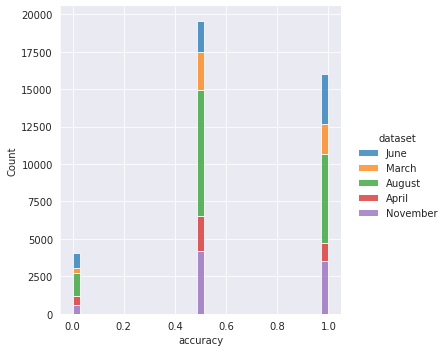

In [76]:
sns.displot(data=analysis_df, x="accuracy", hue="dataset", multiple="stack")
plt.show()

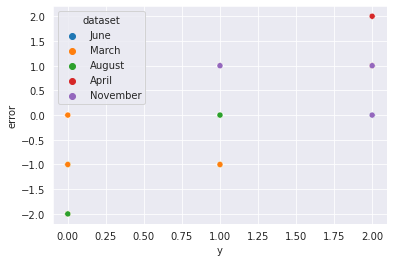

In [77]:
sns.scatterplot(data=analysis_df, x="y", y="error", hue="dataset")
plt.show()

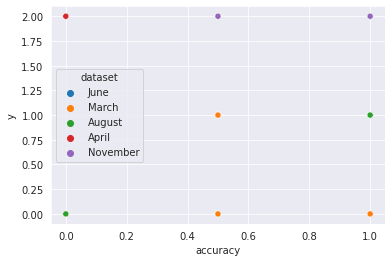

In [78]:
sns.scatterplot(data=analysis_df, x="accuracy", y="y", hue="dataset")
plt.show()

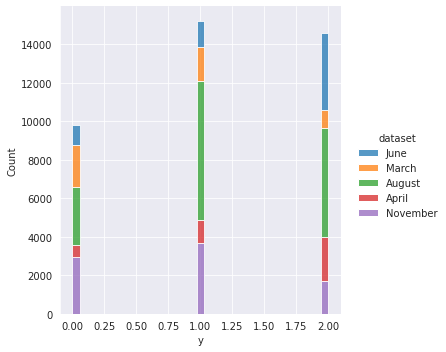

In [79]:
sns.displot(data=analysis_df, x="y", hue="dataset", multiple="stack")
plt.show()

In [80]:
df.columns

Index(['dataset', 'Outside Temperature', 'Avg. Temperature', 'RH', 'va', 'Tg',
       'Gender', 'Age', 'Height', 'Weight', 'Duration', 'Icl',
       'Thermal feeling (global)'],
      dtype='object')

In [81]:
method.get_parameters()

In [82]:
df['Thermal feeling (global)'].value_counts()

 0    124
 1    120
-1     82
Name: Thermal feeling (global), dtype: int64